# How fast would you drive in Monaco?

**Pietro Grandinetti -- January 21, 2021**

## Introduction

In this article I am going to try out statistical inference techniques with the goal to draw insights from a pretty large dataset.

I will touch on several subjects, from Python and PostgreSQL, to data sampling, hypothesis testing and inference, while driven by a business point of view. In other terms, I will put myself at the place of the Data Scientist who's been given the task to provide its business with data-driven, actionable insights.

The content will thus be interesting for those of you who work on any of the following topics:
- Python development
- Database programming and optimization
- Inferential Statistics
- Data Science

## The data (and the story behind it)

Raw data is the fuel behind the most important innovations of these days. It's a pity that many organizations keep their data secret. On the one hand, I understand their reasons; on the other, history has shown that open-source contributions drive innovation like, or even more than, competition.

That's why we set on a mission to publish everything we do and make it reproducible. One of the first things we did was to take a complicated machinery developed by researchers at the Communication Systems Department
of Sophia-Antipolis, France, that was already open-sourced and we made it more easily accessible and 100% reproducible.

The result is... _a lot_ of data.

This is a system that simulates road traffic in the Principality of Monaco for ten hours, starting from 4am. It basically is a fairly large network of roads (think of a graph) inside which vehicles of any type and pedestrians  move (think of objects moving from node to node of a graph).

The key is that every vehicle is equipped with a GPS-like sensor. Therefore, at the end of the simulation, we can retrieve instantaneous positions and speed information for each vehicle. That sounds like a great dataset!

We've done this already, put all data in CSV format as well as loaded them into a PostgreSQL database. Then (suprise!), we simply published the data on the internet. You can download all of them on your computer without even asking permission. And you can reproduce the experiment (or run your own) in a couple of clicks. Careful though, it's many gigabytes of data-- may take a while. I would recommend to first read this through [this article](https://github.com/pgrandinetti/standard-traffic-data/blob/main/knowledge/Urban_Traffic_Data_Exploratory_Analysis.ipynb) that shows some interesting exploratory data analysis done over a subset of the data.

## Data Settings

The dataset is definitely great, though it presents an obvious obstacle to start with: it's a bit too large!

In fact, I am not even sure how many records are there. For sure, it's fixed size, therefore I could theoretically download the CSV, wait for probably a few hours, then run a `wc -l` to know its size, wait several minutes and then I'd get the number. And then... what?

I suspect the dataset contains about 100 million rows, but this information is useless. I also know it's a CSV of around 8 GB (I can see the file size in the browser when it asks me to confirm the download), but this information is not very useful either.

I was not given a cluster of computers with a lot of memory. I am using my laptop with 8G of fast memory. Even if I download the entire file, how am I supposed to load it into memory?

The same problem applies to the PostgreSQL database. For sure the database has a lot of advantages over the CSV file (and the unique disadvantage that you need to know a bit of SQL!), but it comes with problems too. First of all, to maintain it costs money. I was forbidden by my team to run a `select count(*)` which would consume a lot of memory and maybe even take down the CPU of the server that hosts the DB. In a real-world production environment, it may very well be that the system administration has disabled queries that take too much DB memory. Imagine if I were to take down the entire server!

No reason to worry too much though. This is a fairly common situation for data scientists. Whether you were given 1 billion tweets, 500 million pictures, or 100 million payment transactions, you won't be able to analyze the dataset in its entirety.

You and I need a hat.

## Choose the right hat

I need to wear the statistician hat to work on this task.

The database will be the _population_ that I have to study. I will have to come up with _hypothesis_ about this population, driven by _samples_ and _reject_ (or not) them via statistical _testing_ and _evidence_.

Statisticians never assume to know the entire population. Think about healthcare studies: when a company wants to evaluate the effectiveness of a new drug, they certainly don't assume to know how the entire world's population would react to it. They take a sample (volunteers usually), test the drug on this small sample and then make conclusions based on statistical evidence.

This is the correct Data Science approach for large dataset, and it's the one I'll use.

**My approach: ask questions.**

My approach to statistical analysis is to ask questions. These questions will drive sampling and light exploration, and then shape the hypotheses. Once I have some meaningful hypotheses, I will work on them statistically (via confidence intervals and/or hypothesis testing).

## Preliminaries

Once for all, let me install and load all packages I need.

In [ ]:
!pip install pandas
!pip install psycopg2-binary
!pip install numpy
!pip install scipy

In [1]:
import os
import time

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import psycopg2

import concurrent.futures

I follow the best practice to have credentials and other environment variables in a `.env` file. Before I run this notebook, I do `$source .env` which is why now I can find them into `os.environ`. That's how I am going to initialize the database connection.

In [2]:
def db_conn():
    return psycopg2.connect(
        host=os.environ['DB_HOST'],
        port=os.environ['DB_PORT'],
        password=os.environ['DB_PASSWORD'],
        user=os.environ['DB_USER'],
        dbname=os.environ['DB_NAME']
    )
connection = db_conn()
assert connection

That's it for the preliminaries! Let me know go ahead and talk about the cornerstone of this article, _the sampling procedure_.

## Sampling from the population

_Sampling_ literally means to extract a few elements from the population. The most famous example of it is probably the [Urn problem](https://en.wikipedia.org/wiki/Urn_problem).

With respect to urns and health studies I am in a advantageous position. Here the population sits in a database therefore I can take as many samples as I want. There are however a few gotchas to keep in mind:

- I shouldn't rely on the fact that "it's a database so I can look at the whole". In fact, I cannot. Not only because the size is very large, but rather because it's unknown. Somebody may put more data in there, at any time.
- I have be careful on the load I put on the database CPU. Hundreds, or low thousands of records should be fine.
- The samples have to be taken as randomly as possible. As you know, it's not easy to have real randomness in computer systems.

Luckily, PostgreSQL is here for the rescue.

From version 9.5, PostgreSQL supports an operator called [TABLESAMPLE](https://www.postgresql.org/docs/9.5/sql-select.html). Like the name suggests, this allows to take a sample of a table.

Few, very important things to keep in mind:

- `TABLESAMPLE` can be applied either with `SYSTEM` or with `BERNOULLI` as sampling method. The first one is _very_ fast, because it's based on blocks/pages, but (and for the same reason) it's not really random. The latter is slower, but offer better randomization, and is the one I will use.
- It requires a real number between 0 and 100, that represents the percentage of the table to sample. However, the result will not be the _exact_ percentage of rows, just a close number.
- `TABLESAMPLE` is applied _before_ the `WHERE` clause. Hence, if I want to have 100 rows all respecting a certain condition, I have to sample more to try to get close to 100 after the `WHERE` is applied.

This is a very brief overview and you should definitely read up the documentation for more details. There are some takeways for the experiments I will be working on.

To start with, `TABLESAMPLE` can be _seeded_. This is common practice in numerical simulation, to initialize all pseudo-random algorithms with a seed, so that the experiment is reproducible. However, in this case I think it's unnecessary -- it doesn't fit well the inferential set-up, in my opinion. I will not seed the samples, hence keep in mind that when you run the notebook the results may vary slightly.

The second point I want to make is about the percentage used to select the sample. I want to underline that the percentage doesn't offer guarantee on the total number of records in the database, nor it does about the number of rows I will get in output! PostgreSQL _tries_ to select that percentage of rows, but for efficiency reasons it may actually be a different value. In other words, if I use 0.1 and I get back 1000 records, it doesn't mean that there are 10,000 records in total. In fact, if I run the same command again I may get a slightly different number.

Before continuing, let's see `TABLESAMPLE` in action with `BERNOULLI` sampling method. I will ask PostgreSQL to give me 0.001% of the population of vehicle IDs.

In [3]:
query = """
    SELECT timestep_time
           , vehicle_id
    FROM most_0400_1400_1_5
    TABLESAMPLE BERNOULLI (0.0001)
"""
df = %time pd.read_sql(query, connection)
df.info()

CPU times: user 138 ms, sys: 22.6 ms, total: 160 ms
Wall time: 2min 8s
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 82 entries, 0 to 81
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestep_time  82 non-null     float64
 1   vehicle_id     69 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.4+ KB


I captured the execution time with the `%time` magic. As you can see, the _Wall time_, that is the time experienced by me waiting for output, is over 2 minutes. And this for fetching just ~80 records!

Compare it with `TABLESAMPLE SYSTEM`:

In [6]:
query = """
    SELECT timestep_time
           , vehicle_id
    FROM most_0400_1400_1_5
    TABLESAMPLE SYSTEM (0.0001)
"""
df = %time pd.read_sql(query, connection)
df.info()

CPU times: user 3.34 ms, sys: 11.9 ms, total: 15.3 ms
Wall time: 187 ms
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 69 entries, 0 to 68
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   timestep_time  69 non-null     float64
 1   vehicle_id     67 non-null     object 
dtypes: float64(1), object(1)
memory usage: 1.2+ KB


In this case I received the result after just 187 ms. As I said, however, `SYSTEM` fetches pages of data therefore providing not-so-great of randomization.

Now, let's move on to running the experiments and collecting the results.

### Run and save the experimental data

My idea is to run 10 sampling experiments on the population, while trying to get around 1,000 samples in each of them.

Experiments are usually very expensive: you need to find volunteers, pay them, set up everything carefully because you might not get a second chance.
I am definitely in a better position, because my experiments consist of queries sent to a database over the network. Still, I want to be careful and therefore will save the results in a file, so I can refer to that file later, without needing to query the database again.

This can take awhile, as I've shown above with a single query. That's fine though. I still want to try to speed up things and therefore will execute the 10 experiments in a threads pool. Some care is required because I don't want to overstress the database. For what I know, maybe it only accepts one connection at the time!
I think, however, that 10 threads won't be a problem and that, in the worst case, the database will queue the ten connections and respond sequentially. That's OK, I'll go grab some coffee in the meantime.

The code below goes along this lines:

- A thread pool runs the ten experiments.
- Wait then collect the resuls in ten dataframes.
- Append the experiment number to each dataframe in a new column.
- Concatenate all dataframe in one, and save it onto a CSV file.

There are two other points I want to make:

First, there exists a [package](https://github.com/MagicStack/asyncpg) for async queries to PostgreSQL databases, which may be worth looking into. I haven't done it yet, as the efficiency of the data collection part is not very critical for this article.

Second, on the same subject, the ThreadPoolExecutor may not be the best option for this task. Some test is needed, in my opinion. It's well known that ThreadPool is recommended to I/O-bound operations, and database queries surely fall into this bucket. However, to make things more complicated there's the `connection` object and the pandas `read_sql` function.

I had initially created only one `connection` and passed it as argument of each thread, but this somehow made the whole execution sequential. This pattern is commonly used in Web Services (and API), where you definitely don't want to create a new connection for every piece of code that you run to handle an incoming request; it's better to create the connection once and then pass it around.

This didn't work here, as if the `psycopg2` connection object queues the queries in the same connection internally; this is just my guess and I haven't verified it yet. Either way, I decided to make the threads so that each of them creates a new connection, but I also limited the number of workers in the pool to 5. If everything makes sense then the total time for running 10 experiments with 5 workers in a ThreadPool should be the same as running two single queries sequentially, which means ~4 minutes.

In [7]:
def single_experiment():
    query = """
        SELECT timestep_time
               , vehicle_id
               , vehicle_speed
               , vehicle_x
               , vehicle_y
               , vehicle_z
               , vehicle_type
        FROM most_0400_1400_1_5        -- the largest table
        TABLESAMPLE BERNOULLI (0.005)
        WHERE vehicle_type is not NULL -- skip pedestrians
        ;
    """
    with db_conn() as conn:
        df = pd.read_sql(query, conn)
    return df

In [8]:
%%time
n_experiments = 10
workers = 5
with concurrent.futures.ThreadPoolExecutor(max_workers=workers) as executor:
    futures = [executor.submit(single_experiment)
               for _ in range(n_experiments)]

CPU times: user 208 ms, sys: 62.5 ms, total: 270 ms
Wall time: 4min 23s


In [9]:
filep = '/home/pietro/statinf_10exp.csv'
dframes = [f.result() for f in futures]
for i, df in enumerate(dframes):
    df['experiment'] = i + 1
df_tot = pd.concat(dframes)
df_tot.to_csv(filep, index=False)

In [10]:
print(f'Number of samples: {df_tot.shape[0]}')

Number of samples: 30608


OK. The sampled data is saved, so I can reference to it. It seems that I got much more data than I wanted: good.

Now I can finally start the statistical analysis. For real!

Here are a few functions that I will use to clean a bit some dataframe. If you are wondering how do I know that in advance... it's not in advance: I came back to this part of the notebook _after_ I was finished and polished the code and isolated some useful function.

In [11]:
def step_2_time(step):
    """Converts timestamp in seconds from midnight to H:M:S string format."""
    return time.strftime('%H:%M:%S', time.gmtime(step))


def drop_speed_below(df, label, value=1):
    """Drop rows from dataframe with valules in column `label` below `value`.
    Returns a new dataframe."""
    rows = df[df[label] < value].index
    return df.drop(rows)


def get_experiment(df, experiment, col='experiment'):
    """Get all rows corresponding to a given experiment number.
    Returns a new dataframe."""
    exp_i_rows = df[col] == experiment
    return df.loc[exp_i_rows].copy()


def convert_speed(df, label='vehicle_speed'):
    """Add two columns to the dataframe:
        - `vehicle_speed [km/h]`
        - `speed_int`
       The `speed_int` is the speed value in km/h truncated to its integer part.
       Modifies the same dataframe in place.
    """
    df[label + ' [km/h]'] = df[label].apply(lambda x: x * 3.6)
    df['speed_int'] = df[label + ' [km/h]'].apply(lambda x: int(x))

## Question: What is the average speed vehicles travel at?

The average speed of any vehicle in a city is standard, basic indicator of whether traffic is fluid or not. There are a lot of caveats to this statement, because the speed is heavily affected by the type of vehicle, the type of road and the time in the day. Despite these many variables, average speed is still a good indicator.

The sampling method I used to get ten samples from the poulation is such that the samples don't have a pattern with respect to vehicle type, road type and timestamp. Thus, I can assume that the distribution of vehicles, roads and timestamps in their categories is a fair representation of the real (population's) distribution.

Before anything else, I want to take a quick look at one of the experiments and the vehicles' speed values therein.

In [12]:
df1 = get_experiment(df_tot, 1)
print(f'Number of samples in experiment 1: {df1.shape[0]}')
convert_speed(df1)
df1.head()

Number of samples in experiment 1: 3111


,timestep_time,vehicle_id,vehicle_speed,vehicle_x,vehicle_y,vehicle_z,vehicle_type,experiment,vehicle_speed [km/h],speed_int
0,43545.0,pedestrian_3-1_2290_tr,0.07,5386.15,2883.33,54.10,passenger1,1,0.252,0
1,43545.0,pedestrian_3-1_3011_tr,0.02,4318.94,1494.53,44.16,passenger2b,1,0.072,0
2,43550.0,pedestrian_3-1_4234_tr,0.03,4102.45,1406.34,125.78,passenger2a,1,0.108,0
3,43550.0,pedestrian_GW1-1_202_tr,0.00,4721.84,1522.93,8.25,passenger2b,1,0.000,0
4,43555.0,pedestrian_GW1-1_217_tr,0.04,4562.51,2204.12,73.47,passenger2a,1,0.144,0


Mean speed value: 3.91 km/h
Speed standard deviation: 13.16 km/h
Mean speed value (only > 1 km/h values): 38.54 km/h
Speed standard deviation (only > 1 km/h values): 20.6 km/h


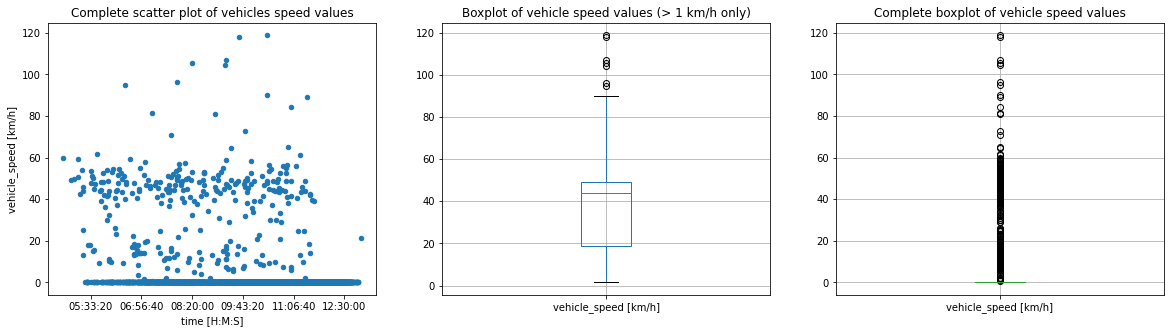

In [13]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))
ax0 = axes[0]
ax1 = axes[1]
ax2 = axes[2]
speed_col = 'vehicle_speed [km/h]'
time_col = 'timestep_time'
time_ax_label = 'time [H:M:S]'
fig1 = 'Complete scatter plot of vehicles speed values'
fig2 = 'Boxplot of vehicle speed values (> 1 km/h only)'
fig3 = 'Complete boxplot of vehicle speed values'

xticks = [20e3, 25e3, 30e3, 35e3, 40e3, 45e3]
df1.plot.scatter(y=speed_col,
                 x=time_col,
                 xticks=xticks,
                 ax=ax0);
ax0.set_xlabel(time_ax_label);
ax0.set_xticklabels([step_2_time(tick) for tick in xticks]);
ax0.set_title(fig1);

df_tmp = drop_speed_below(df1, speed_col)
df_tmp.boxplot(speed_col, ax=ax1);
ax1.set_title(fig2);

df1.boxplot(speed_col, ax=ax2);
ax2.set_title(fig3);

mu = np.round(np.mean(df1[speed_col]), 2)
dev = np.round(np.std(df1[speed_col]), 2)
print(f'Mean speed value: {mu} km/h')
print(f'Speed standard deviation: {dev} km/h')
mu_1 = np.round(np.mean(df_tmp[speed_col]), 2)
dev_1 = np.round(np.std(df_tmp[speed_col]), 2)
print(f'Mean speed value (only > 1 km/h values): {mu_1} km/h')
print(f'Speed standard deviation (only > 1 km/h values): {dev_1} km/h')

This very, very brief exploratory analysis reveals a few things worth noting:

**There are a lot of time instants where a lot of vehicles have speed equals to zero!** This actually makes sense: in a city, the stop-and-go dynamics is the most common. That being said, it's important to keep this in mind because zeros will inevitably drive down the overall average, while not being necessarily bad, or wrong things.

With a timeseries dataset I could go deeper into this and find alternatives that take this problem into account. I could, for instance, consider the average for each vehicle computed over a few consecutive time steps; the idea is that if the average was low for many consecutive time instants, then it would mean something's not working well; if it was for one time instant only (or few of them) then it's a normal occurrence.

Even if the data I have is _technically_ a timeseries, the sampling procedure creates a lot of "holes" in it. There are many techniques to fill holes in timeseries (they go under the name of "data inputation" techniques); none of them is perfect, everyone is worth trying. But the data I have it has so many missing timestamps (due to the sampling) that it looks more like a random walk inside the population, rather than a timeseries. Hence, I will not try any data inputation, and focus solely on statistical inference.

**On the other hand, non-zero values do make sense**. When I briefly looked at this sample distribution with a boxplot by first removing speed values lower than 1 km/h, then I can tell that such distribution is reasonable. This is the plot in the center of the figure above. For an explanation of boxplot I recommend the [Wikipedia page](https://en.wikipedia.org/wiki/Box_plot).

**When including zero values, nothing makes sense anymore**. I added a third plot (far right) that is a boxplot of the whole sample (hence, not removing any speed value). The very high number of zero values makes the distribution so skewed that it doesn't offer any meaningul insight (the box is collapsed somewhere near the zero). This is a repetition of the concept expressed in the first point above.

**The standard deviation is big anyway**. No matter if I include zero-valued speed samples or not, the standard deviation turns out to be a pretty big number. The so-called _coefficient of variation_, computed by dividing the standard deviation over the mean value, is much higher than 1 --hence very large. I already know that this will make my confidence interval less _confident_, but at the same time it's a good descriptor of the population.

This brief analysis was done on just one of the ten samples that I got. By using it I found that the average vehicle speed is 3.91 km/h (or 38.5 km/h if speed values lower than 1 km/h were excluded) with a standard deviation of 13.16 km/h (or 20.6 km/h).

This sample contains 3111 samples. It's a very small number, as I know that the overall database contains more than 80 million datapoints. However, according to theory, we know that the sample mean is an estimator of the population mean (the true mean), and the sample standard deviation is an estimator for the population std (the true std), by a factor equal to `sqrt(3111)`.

I could then stop here and start making inferential reasoning with this data. However, thanks to the Central Limit Theorem, we also know that the mean of the sample means is the better estimator of the true population mean, as it converges to the center of the population.

In other words: every time I collect a sample ("sample" in the general sense, it can be a sample of 3111 datapoints), this comes with a sample mean. **Such mean is also a realization of a random variable**, for the very simple reason that I can keep collecting samples and compute the sample mean for each of them.
The collection of all these sample means is the distribution of the sample means. And (finally) the Central Limit Theorem says that a lot of samples will make the average of the sample means distribution equal to the true population average.

This was a lot of words simply to say that is definitely worth looking at the other 9 extracted samples, and to their average values, to see what's the distribution of the ten sampled means.

The next thing I want to do now is to take a look at the individual samples' mean values (for the speed). I am just curious to see if they all have similar values or there are outliers.

In [14]:
all_mu = []
all_std = []
all_mu_1 = []
all_std_1 = []
new_col = 'vehicle_speed [km/h]'
speed_col = 'vehicle_speed'
for i in range(1, 11):
    df_ = get_experiment(df_tot, i)
    print(f'Number of samples in experiment {i}: {df_.shape[0]}')
    convert_speed(df_, label=speed_col)
    mu_ = np.round(np.mean(df_[new_col]), 2)
    all_mu.append(mu_)
    dev_ = np.round(np.std(df_[new_col]), 2)
    all_std.append(dev_)
    df_tmp_ = drop_speed_below(df_, new_col)
    #df_tmp_ = df_.loc[df_[new_col] > 1]
    mu_1_ = np.round(np.mean(df_tmp_[new_col]), 2)
    all_mu_1.append(mu_1_)
    dev_1_ = np.round(np.std(df_tmp_[new_col]), 2)
    all_std_1.append(dev_1_)
    
print(f'Sample means (10 samples): {all_mu}')
print(f'Sample means (10 samples, only > 1 km/h values): {all_mu_1}')

Number of samples in experiment 1: 3111
Number of samples in experiment 2: 3063
Number of samples in experiment 3: 3021
Number of samples in experiment 4: 3069
Number of samples in experiment 5: 3051
Number of samples in experiment 6: 3093
Number of samples in experiment 7: 3109
Number of samples in experiment 8: 3044
Number of samples in experiment 9: 3053
Number of samples in experiment 10: 2994
Sample means (10 samples): [3.91, 3.97, 4.01, 3.84, 3.47, 3.87, 4.4, 3.83, 4.01, 4.1]
Sample means (10 samples, only > 1 km/h values): [38.54, 37.89, 38.16, 38.0, 36.75, 38.43, 39.45, 38.92, 40.83, 40.8]


The values are consistent each with the others. This means that the _adjustment_ each new sample does to the previous ones, to steer the overall mean towards the real population's mean, is not very big. Even then, it's worth in my opinion to take a look at how confidence increases with the increase of the samples.

To look at this, I will plot the distribution of the first sample and draw a line at its sample average. Then I will merge the first two samples, plot the resulting distribution and look at its average. Then, the same with the first three samples; and so on until I have merged all of them.

What I expect is a slight change to the average everytime I add one more sample, and these small changes are such that eventually the average will be very close to the true (unknown) population's average.

### Confused? Read this!

As I was reading this notebook again, I realized this could be a good place to pause for a minute and clarify a few things. I suspect you may have a question: _What the heck is this guy doing with all these "samples", "populations", "averages" and whatnot?_

In fact, I am going through a very simple statistical result, one that everybody knows well. I will now draw the comparison between what I am doing here and the most famous statistical benchmark: flipping a 2-sided coin.

The experiment with a coin is very simple: you flip the coin ten times and you count how many tails vs heads you got. Thus, you run one experiment and you get 7 heads vs 3 tails. Weird, but can happen.

If you stopped there you would conclude that flipping a coin has 70% probability to give head. Or, if we assign 1 to head and 0 to tail, you would conclude that the average value of the coin is 0.7.

But you know that's just one experiment.

So you do it again: 6 tails, 4 heads. Average 0.4.

And again: 3 tails, 7 heads. Average 0.7.

And again: 2 heads, 8 tails. Average 0.2.

And again. And again. And ... again.

Every time you run one experiment and compute the average of that experiment, that's just the sample average. If you collect all such sample averages, then you have another sample: the sample of the averages of the experiments.

The crucial point (stated by the Central Limit Theorem) is that, if you collect many sample averages, then **the mean value of all such averages is a very good estimate of the true average of a coin**. Which we know it's 0.5. Go ahead, take a coin and run a lot of experiments (you do need many of them to converge to 0.5) and check yourself.

These are the ideas that I am applying here!

**Now, back to the analysis.** What I am going to do next is a lot of barplots. A barplot can show quickly how the distribution of values look like. I will do one bar plot for the first sample only, another for the first and second sample merged, and so on.

There's a caveat though. Speed values are real number. Barplot is a categorical plot, hence if I do it directly on the dataframe then it's like that I will have a lot of "categories" with one value only. For example, a vehicle's detected speed can be 20.23 km/h and that's a very specific value. It's likely that there's only one occurrence of such a value.

To solve this problem I will just truncate the speed values to their integer part. Brutal, but I think it will be fine for this use case.

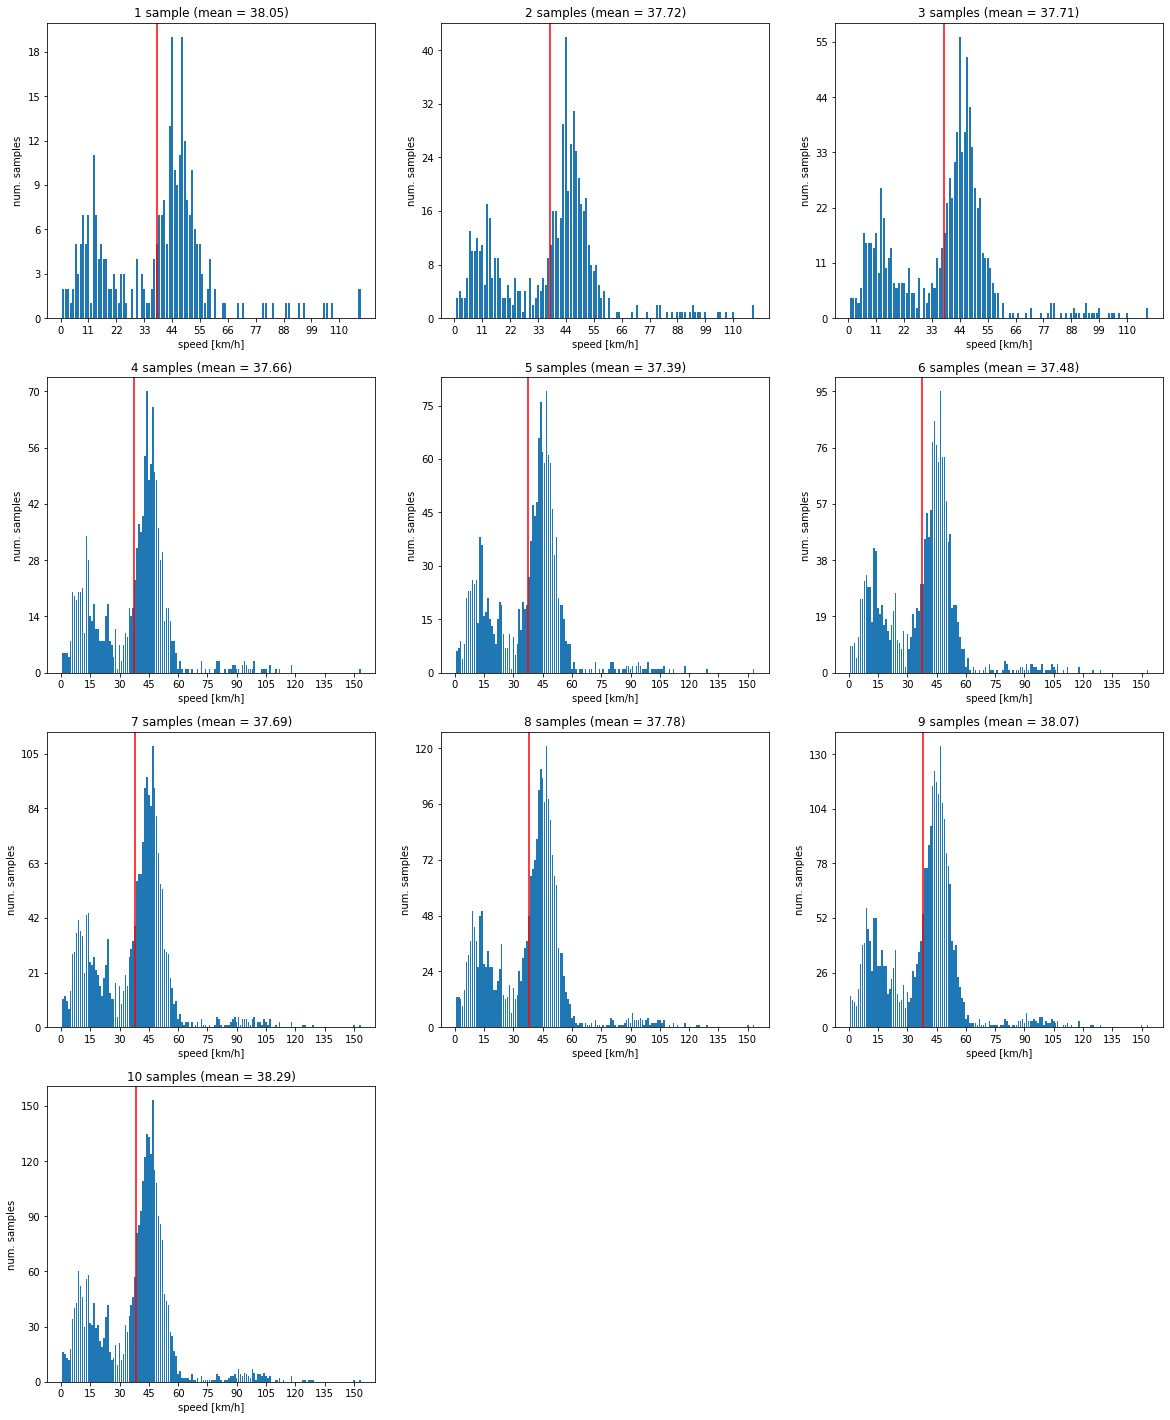

In [15]:
# This will contain 10 subplots
figure = plt.figure(figsize=(20, 25))

# Start from the first experiment
current_df = get_experiment(df_tot, 1)
speed_col = 'vehicle_speed'
speedkm_col = 'vehicle_speed [km/h]'
new_col = 'speed_int'
convert_speed(current_df, label=speed_col)
current_df = drop_speed_below(current_df, new_col)

all_avg = [np.round(np.mean(current_df[new_col]), 2)]

for i in range(1, 11):
    if i > 1:
        # If not first iteration
        # then cumulate the next sample.
        df_exp_i = get_experiment(df_tot, i)
        convert_speed(df_exp_i, label=speed_col)
        df_exp_i = drop_speed_below(df_exp_i, new_col)
        all_avg.append(np.round(np.mean(df_exp_i[new_col]), 2))
        current_df = pd.concat([current_df, df_exp_i])

    # Plot the cumulated-so-far samples
    current_ax = figure.add_subplot(4, 3, i)
    toplot = pd.value_counts(current_df[new_col]).sort_index()
    x = list(toplot.index)
    y = list(toplot)
    current_avg = np.round(np.mean(all_avg), 2)
    if i > 1:
        title = f'{i} samples'
    else:
        title = '1 sample'
    title += f' (mean = {current_avg})'
    current_ax.bar(x=x, height=y)
    plt.title(title);
    plt.xticks(list(range(0, np.max(x) + 1, int(np.max(x) / 10))));
    plt.yticks(list(range(0, np.max(y) + 1, int(np.max(y) / 5))));
    plt.axvline(x=current_avg, color='red');
    plt.xlabel('speed [km/h]')
    plt.ylabel('num. samples')

First, let me state the most important insight from the figure above. If I had a doubt about what distribution the vehicles' speed follows just by looking at the first subfigure, then by looking at the last one there's now doubt anymore: it's a gaussian with two peaks (bells).

In fact, I find it very impressive that the shape of the distribution changes slightly from figure to figure, and **it slowly converges to the final shape**. Yes, distributions do converge.

In simpler (and more intuitive) words, you may say that the number of outliers decreases as I keep cumulating more samples, and therefore when looking a the whole picture the shapes of the distribution becomes more and more clearly defined.

I had already checked that the sample averages don't differ too much one from the others. These plots show the same, though from a different point of view: as I keep cumulating samples, the overall average doesn't change much. It changes slowly and slightly, like the entire distribution does.

Thus, I can conclude that **the sample average distribution has converged to a value that is close to 38.3 km/h**. And therefore, that's a good estimate of the real vehicles' speed.

That's just a number though. If I were asked "how fast do vehicles drive in Monaco?" I could answer "They drive at 38.3 km/h, in average". But with what certainty would I answer that?

The graphs above clearly show that the sample average is not even aligned with the center of the most prominent peak; that's because the other peak steers the average value towards itself a bit. Thus, I would answer 38.3 km/h when in reality the most common value (the mode) is closer to 45 km/h. If you followed this article along, now you could type

```
st.mode(current_df['speed_int'])
```

and it would tell you the most frequently seen value of speed. It gave me 47 km/h, but remember that it may differ a bit from what you see, due to the "realistic" sampling procedure.

The point I am making here is that responding to that question with just a value can be harmful: it doesn't really give good insights about the system under analysis.

What I need is to come up with statistical evidence supporting the numerical values. Confidence intervals will do it nicely.

This type of computation in Python is very easy. I will start by computing the range of velocity values that has 95% probability to be the actual value of a sampled vehicle.

In [16]:
obj = current_df['speed_int']
conf = 0.95
length = len(obj)
scale = st.sem(obj)
loc = np.mean(obj)
intv = st.t.interval(conf, length, loc=loc, scale=scale)
print(f'95% confidence interval for speed values [km/h]: {intv}')

95% confidence interval for speed values [km/h]: (37.60096829109406, 38.9857512331874)


In other words, this means that there's a 95% probability that the actual average value of a vehicle is between 37.6 and 38.9 km/h.

Is that not high enough as certainty? Then, let's take the 99% confidence interval:

In [17]:
conf = 0.99
intv = st.t.interval(conf, length, loc=loc, scale=scale)
print(f'99% confidence interval for speed values [km/h]: {intv}')

99% confidence interval for speed values [km/h]: (37.3831930728994, 39.20352645138206)


As you could expect, having a higher confidence implies having a broader range. In this case I could say that the average speed value of a vehicle is between 37.38 and 39.2 km/h with 99% probability.

Is that too broad of a range? Let's say you need a more narrow interval, then let's compute the 85% confidence interval.

In [18]:
conf = 0.85
intv = st.t.interval(conf, length, loc=loc, scale=scale)
print(f'85% confidence interval for speed values [km/h]: {intv}')

85% confidence interval for speed values [km/h]: (37.78489448014104, 38.80182504414043)


The interval is narrow indeeed. It tells us that in 85% of cases, a vehicle will have a speed between 37.78 and 38.8 km/h. That's a widht of just 1 km/h and, not surprisingly, it includes the sample average that I computed by cumulating all samples (that was 38.29 km/h in the last of the ten figures).

Here's a summary of the three confidence intervals I computed.

| Confidence | Lower bound [km/h] | Upper bound [km/h]|
| ---        | ---                | ---               |
| 0.99       | 37.38              | 39.2              |
| 0.95       | 37.6               | 38.98             |
| 0.85       | 37.78              | 38.8              |

There's no right or wrong value of confidence interval. It all depends on your application and what insights you are trying to generate to provide value as a Data Scientist. It's only based on this information that you can decide what confidence interval is most useful for you.

**What about the stop-and-go effect?**

Right. I did remove brutally the speed values lower than 1 km/h before doing the inferential part of the analysis. What happens if I consider those values too?

I expect the distribution will be so skewed towards the left part of axis (that is, the zero value) that it will not give any useful information other than... vehicles are really slow!

Let's try. The code is the same as in the previous plot, I just need to remove the line that drops speed values below the threshold.

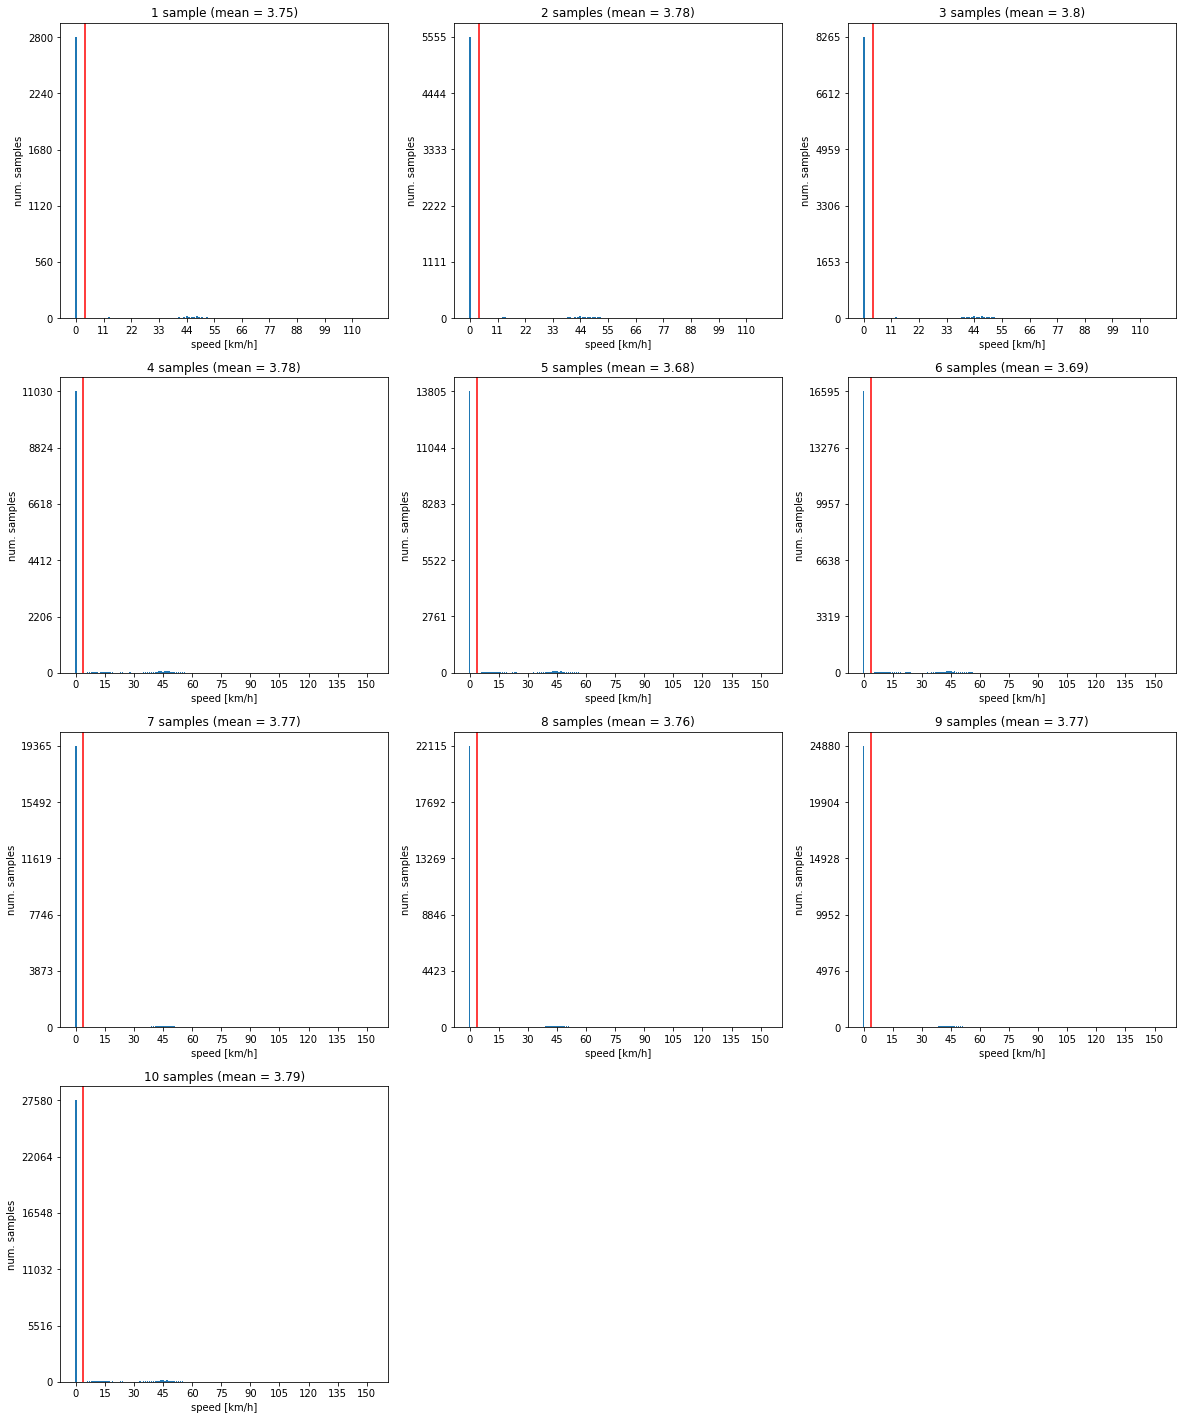

In [19]:
# This will contain 10 subplots
figure = plt.figure(figsize=(20, 25))

# Start from the first experiment
current_df = get_experiment(df_tot, 1)
speed_col = 'vehicle_speed'
speedkm_col = 'vehicle_speed [km/h]'
new_col = 'speed_int'
convert_speed(current_df, label=speed_col)

all_avg = [np.round(np.mean(current_df[new_col]), 2)]

for i in range(1, 11):
    if i > 1:
        # If not first iteration
        # then cumulate the next sample.
        df_exp_i = get_experiment(df_tot, i)
        convert_speed(df_exp_i, label=speed_col)
        all_avg.append(np.round(np.mean(df_exp_i[new_col]), 2))
        current_df = pd.concat([current_df, df_exp_i])

    # Plot the cumulated-so-far samples
    current_ax = figure.add_subplot(4, 3, i)
    toplot = pd.value_counts(current_df[new_col]).sort_index()
    x = list(toplot.index)
    y = list(toplot)
    current_avg = np.round(np.mean(all_avg), 2)
    if i > 1:
        title = f'{i} samples'
    else:
        title = '1 sample'
    title += f' (mean = {current_avg})'
    current_ax.bar(x=x, height=y)
    plt.title(title);
    plt.xticks(list(range(0, np.max(x) + 1, int(np.max(x) / 10))));
    plt.yticks(list(range(0, np.max(y) + 1, int(np.max(y) / 5))));
    plt.axvline(x=current_avg, color='red');
    plt.xlabel('speed [km/h]')
    plt.ylabel('num. samples')

Ups. Yeah, not very useful. The occurrence of very low values is so high that I almost can't see the other speed values on the plots! This is definitely not helpful here, but it does raise an additional question: Do vehicles spend a lot of time at so low speed values? That's a question for another article though.

**The real power of this analysis**

And so I've got my nice confidence intervals that I can discuss with my team and take decisions based on this information. Confidence interval are indeed one of the most useful statistics to drive business decisions.

The real reason why I wanted to go through all of the steps above is more subtle though.

What I explained so far is a standard approach to data analysis that can be reproduced for more questions as well as for different datasets:
- Get the dataset.
- Sample it with a randomized procedure.
- Analyze the distrubution of the samples.
- Make inferential reasoning (statistical) based on the samples distribution.

This reasoning model has helped me countless times. Now you can make it yours, if you wish.

Let's see it applied to a different data-drive question (but with some twists!).

## Question: What is the maximum capacity of the network?

I want to know, with a certain statistical confidence, what is the maximum number of vehicles travelling the network at the same time. In absence of more information, I will assume that is also the maximum capacity of the city (even though it may not really be packed up yet).

Before getting into any confidence interval calculation and hypothesis testing, let's take a look at a portion of the data that I have, as in a brief exploratory analysis.

I will take the subset of the samples given by the first experiment only and look at the distribution of the network capacity there.

In [20]:
df1 = get_experiment(df_tot, 1)
print(f'Samples in experiment 1: {df1.shape[0]}')
df1_grouped = df1.groupby('timestep_time')
print(f'Unique time steps in experiment 1: {len(df1_grouped.groups)}')

Samples in experiment 1: 3111
Unique time steps in experiment 1: 2260


Mm. I need to stop right here. Can you see the problem?

In the first experiment I collected 3111 samples. Among them, there are 2260 unique timesteps. Overall, it looks like the `TABLESAMPLE BERNOULLI` did a great job at diversifying!

But in this specific case, this raise an issue. I was going to count the number of vehicles for each unique timesteps, but with the numbers so close (3111 samples and 2260 unique timesteps) it is likely that each sampled timestep only contains information about one vehicle.

Let's take a look at the maximum size of the timestep groups.

In [21]:
max_l = max(len(v) for v in df1_grouped.groups.values())
print(f'Largest timestep group size: {max_l}')

Largest timestep group size: 6


This means that the largest number of samples I got for the same timestep is six. And that implies that if I count the number of vehicles at every timestep I will get at most six of them. But this clearly isn't the maximum network capacity, it's just a sampling issue!

I need a different approach. What if I think from a vehicle point of view, instead of a timestep point of view?

I could find unique vehicle IDs, then for each of them find the first and last timestep in the dataset that vehicle appears in. This should give me the window of timesteps that vehicle was inside the network.
Then I could overlap this window with the other vehicle's window, so to find the largest intersection of them all. That would give me the largest number of vehicles that _might_ be inside the network at the same time.

Why _might_? Because I have no way to know whether a vehicle exited the network and then entered it again. I will have to make the assumption that this doesn't happen.

All this sounds a bit too much for a "brief" exploratory look, not to mention that I am not sure what type of statistical confidence I could infer from it. Anyway, let me try.

In [22]:
def find_min_max_time_veh(vehicle_id: str,
                          df: pd.DataFrame) -> tuple:
    """Finds the min and max timestep for the given vehicle_id"""
    afilter = df['vehicle_id'] == vehicle_id
    filtered = df.loc[afilter]
    min_ = min(filtered['timestep_time'])
    max_ = max(filtered['timestep_time'])
    return (min_, max_)


def veh_time_inside(min_: float, max_: float) -> int:
    """Number of steps a vehicle was inside the network.
    *Note* It assumes the vehicle didn't leave and come back.
    """
    return int(max_ - min_)

df1_grouped_veh = df1.groupby('vehicle_id')
print(f'Unique vehicles in experiment 1: {len(df1_grouped_veh.groups)}')

all_times = df1_grouped_veh.apply(lambda x: find_min_max_time_veh(x.iloc[0]['vehicle_id'], df1))
new_df = pd.DataFrame({
    'vehicle_id': all_times.index,
    'min_': [t[0] for t in all_times],
    'max_': [t[1] for t in all_times]
})
new_df['window'] = new_df.apply(lambda x: veh_time_inside(x['min_'], x['max_']), axis=1)
max_time_inside = max(new_df['window'])
print(f'Max vehicle time experiment 1: {max_time_inside}')
num_veh_traced = sum(new_df['window'] > 0)
print(f'Number of vehicles detected in more than 1 timestep (experiment 1): {num_veh_traced}')

Unique vehicles in experiment 1: 2872
Max vehicle time experiment 1: 20375
Number of vehicles detected in more than 1 timestep (experiment 1): 229


Here's what I have got:

- In experiment 1, 229 vehicles were samples more than once.
- In experiment 1, the largest number of steps a vehicle is inside the network is 20375. That's seconds, so more than 5 hours. I bet is a bus.

Let's think about the extreme case. Even if the time windows for those 229 vehicles overlapped, I could only conclude that the network handles 229 vehicles at the same time. That's obviously too low.

And even if those time window were exactly the same for 200 vehicles more for every other experiment, that would mean there are around 200 vehicles at the same in the network but... with what statistical confidence could I say it? It sounds like plain coincidence.

Again, it feels as if I don't have enough data to answer this question.

I will then go back to the source of data. Overall, the problem I am having so far is that the collected data seems to be taken from a GPS system that can can cover the whole city but can only look at some random vehicles in every time steps.

In other words, it cannot follow a vehicle.

Can I get data that instead is more similar to a in-vehicle GPS system? For sure, but then I have to be careful because doing it for _all_ vehicles would result in too much data to transmit, load in memory and analyze.

I am going to try to select samples from the database as if they were taken by a satellite. The satellite can take "screenshots" of the systems at given time instants. No system is perfect though, so the satellite can't really know _everything_. It can count though, so let's have it count the number of vehicles in those time instants.

Like before, I will run multiple experiments (data extractions, really). The code is similar to the one used before, so let me skip the details this time.

In [23]:
def satellite_experiment():
    query = """
        SELECT timestep_time
               , count(vehicle_id) as num_veh
        FROM most_0400_1400_1_5
        WHERE timestep_time in (
            -- Randomly choose at what timesteps the system
            -- can be "photographed".
            SELECT distinct timestep_time
            FROM most_0400_1400_1_5
            TABLESAMPLE BERNOULLI (0.01)
        )
        GROUP BY timestep_time
        ;
    """
    with db_conn() as conn:
        df_sat = pd.read_sql(query, conn)
    return df_sat

In [24]:
%%time
n_sat_experiments = 10
sat_workers = 10
with concurrent.futures.ThreadPoolExecutor(max_workers=sat_workers) as executor:
    futures = [executor.submit(satellite_experiment)
               for _ in range(n_sat_experiments)]

CPU times: user 217 ms, sys: 51.7 ms, total: 269 ms
Wall time: 6min 23s


In [25]:
filep = '/home/pietro/statinf_satexp.csv'
dframes = [f.result() for f in futures]
for i, df in enumerate(dframes):
    df['experiment'] = i + 1
df_sat = pd.concat(dframes)
df_sat.to_csv(filep, index=False)

In [26]:
df_sat.head()

,timestep_time,num_veh,experiment
0,17755.0,34,1
1,17775.0,35,1
2,18230.0,358,1
3,18280.0,423,1
4,18290.0,433,1


In [27]:
df_sat.shape

(42278, 3)

In [28]:
df1_sat = get_experiment(df_sat, 1)
num_steps = df1_sat.shape[0]
avg_capacity = np.round(np.mean(df1_sat['num_veh']), 2)
max_capacity = np.max(df1_sat['num_veh'])
std_capacity = np.round(np.std(df1_sat['num_veh']), 2)
print(f'Time instants sampled in experiment 1: {num_steps}')
print(f'Average capacity in experiment 1: {avg_capacity} vehicles')
print(f'Max capacity in experiment 1: {max_capacity} vehicles')
print(f'Capacity standard deviation in experiment 1: {std_capacity} vehicles')

Time instants sampled in experiment 1: 3696
Average capacity in experiment 1: 12432.83 vehicles
Max capacity in experiment 1: 18644 vehicles
Capacity standard deviation in experiment 1: 5088.86 vehicles


OK, it seems like I've got some real data this time! In one time instant there were 18644 vehicles. Let's say in average a vehicle has the dimension of a 2 meters x 4 meters rectangle. That makes 149,152 squared meters occupied by vehicles, at that time instant. Which is around 1/5th of the area covered by the simulation. It sounds like a reasonable number, considering that most of the area is not available to vehicles (there are mostly buildings, and hopefully parks or other non-transit zones).

This was just a sanity check, very rough but useful in my opinion. The numbers make sense.

I will now apply to this question the same analysis strategy that I used before. Let's see where it gets me.

First of all, I will take a look at the distribution for this sample only.

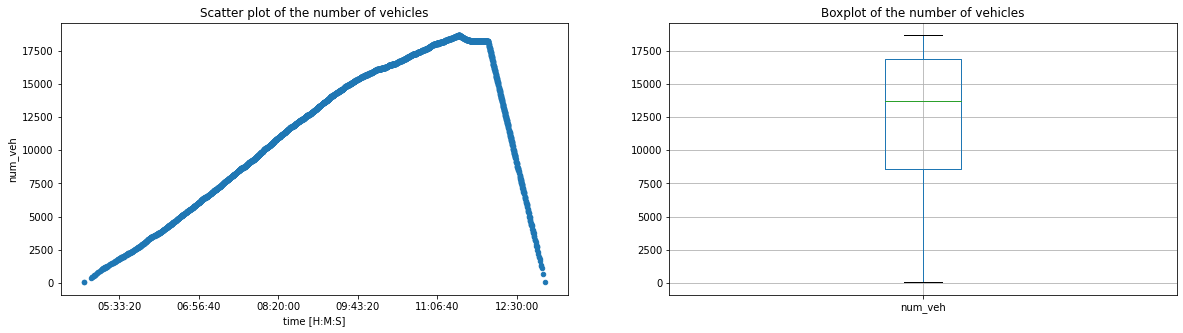

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
ax0 = axes[0]
ax1 = axes[1]
veh_col = 'num_veh'
time_col = 'timestep_time'
time_ax_label = 'time [H:M:S]'
fig1 = 'Scatter plot of the number of vehicles'
fig2 = 'Boxplot of the number of vehicles'

xticks = [20e3, 25e3, 30e3, 35e3, 40e3, 45e3]
df1_sat.plot.scatter(y=veh_col,
                     x=time_col,
                     xticks=xticks,
                     ax=ax0);
ax0.set_xlabel(time_ax_label);
ax0.set_xticklabels([step_2_time(tick) for tick in xticks]);
ax0.set_title(fig1);

df1_sat.boxplot(veh_col, ax=ax1);
ax1.set_title(fig2);

Interestingly, the number of vehicles when plotted against the sampled time instants looks like a normal function. But **remember this**: there are actually a lot of "holes" in that function, because I sampled the time instants randomly. Hence, I don't really know if for a time instant that wasn't sampled the number of vehicles is suddenly zero. But I agree with you that is very unlikely.

The box plot on the right is the distribution plot, just in a different form. It looks much nicer than the data I analyzed before. There's a well defined median, clear quartiles and so on.

Now I would like to plot the distrubution for this sample (experiment 1) in the classical form (that is a bar plot), that shows the number of times a certain value has occurred. However, this is a bit more tricky than before.

The problem is that the value I want to see is a discrete counter of the vehicles. Thus, each such number is relatively unlikely to occurr a lot of times. For instance, if at a given time step there are 10,001 vehicles, that's a very specific number. I will surely have 10,000 in a different time step, maybe 10,002 as well, but maybe never again the same exact values.

This means that a bar plot could just a lot of bars with low height, since the heights are the number of occurrences of each value. Let's take a look nonetheless.

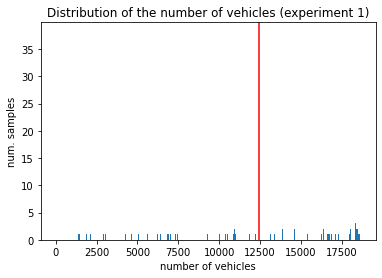

In [30]:
col = 'num_veh'
toplot = pd.value_counts(df1_sat[col]).sort_index()
x = list(toplot.index)
y = list(toplot)
avg = np.round(np.mean(df1_sat[col]), 2)
title = 'Distribution of the number of vehicles (experiment 1)'
plt.bar(x=x, height=y)
plt.title(title);
plt.axvline(x=avg, color='red');
plt.xlabel('number of vehicles');
plt.ylabel('num. samples');

Not very useful, as expected. To say the truth, in terms of aggregated statistics the box plot above says it all. Nonetheless, I want to take a look at a bar plot for this distrubution.

The common solution to this problem is to use histogram. A histogram is a plot with bins, and the width of every bin is decided based on the distrubution. Matplotlib handles it off-the-shelf, but basically is like fixing a bucket width (say, 100) and assign all values into a bucket (say, all values between 0 and 100 go in bucket one, all those between 101 and 100 go in bucket two, and so on).

For the sake of the argument, I will plot the histogram computed by matplotlib alongside a bar plot of manually computed buckets.

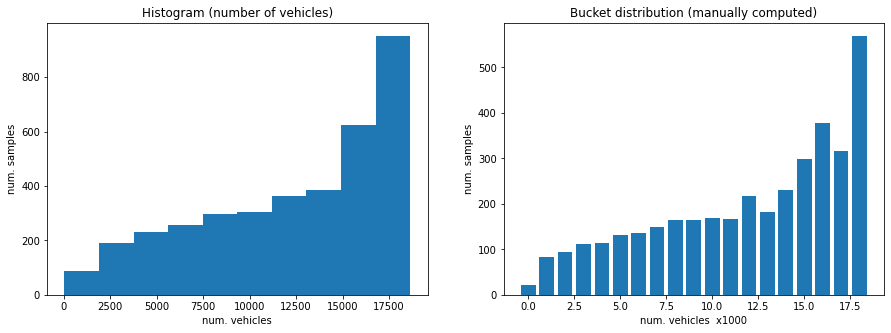

In [31]:
new_col = 'bucket'
bucket = 1000
df1_sat[new_col] = df1_sat['num_veh'].apply(lambda x: int(x / bucket))

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax0 = axes[0]
ax1 = axes[1]

ax0.hist(df1_sat['num_veh'], density=False)
ax0.set_title('Histogram (number of vehicles)')
ax0.set_xlabel('num. vehicles')
ax0.set_ylabel('num. samples')

toplot = pd.value_counts(df1_sat[new_col]).sort_index()
x = list(toplot.index)
y = list(toplot)
title = 'Bucket distribution (manually computed)'
ax1.bar(x=x, height=y);
ax1.set_title(title);
ax1.set_xlabel(f'num. vehicles  x{bucket}');
ax1.set_ylabel('num. samples');

The good news is that the figures now makes sense (and they are similar, so I wasn't totally off road!). The bad news is that the distribution looks uniform-ish. There's a clear increase of frequency for larger values of number of vehicles (that means higher values are in the right half of the figure), but other than that there's no clear pattern.

In my opinion, the increase of number of samples with higher number of vehicles can be explained intuitively: when there are a lot of vehicles they travel more slowly and therefore leave the city at slower rate. Thus, the actual number of vehicles stays similar for more time instants, hence it occurs more times.

Apart from this speculation of mine, I have another problem with uniform distributions: I don't find their confidence intervals very useful.

To be clear, t-intervals like the ones I've computed before with `st.t.interval(...)` are quite robust to non-gaussian distributions. Even then, a uniform distribution is a weird beast: all values are equally likely to occur! As such, a confidence interval will be quite the same (in terms of width) for all values, not just the mean.

If I were in a situation like this, I would bring up to my team's attention the chart above rather than a confidence interval or other inferential reasoning.

Now, with the same strategy that I already used twice, I am going to cumulate all samples from the satellite in a growing distribution and look at it _as it cumulates_.

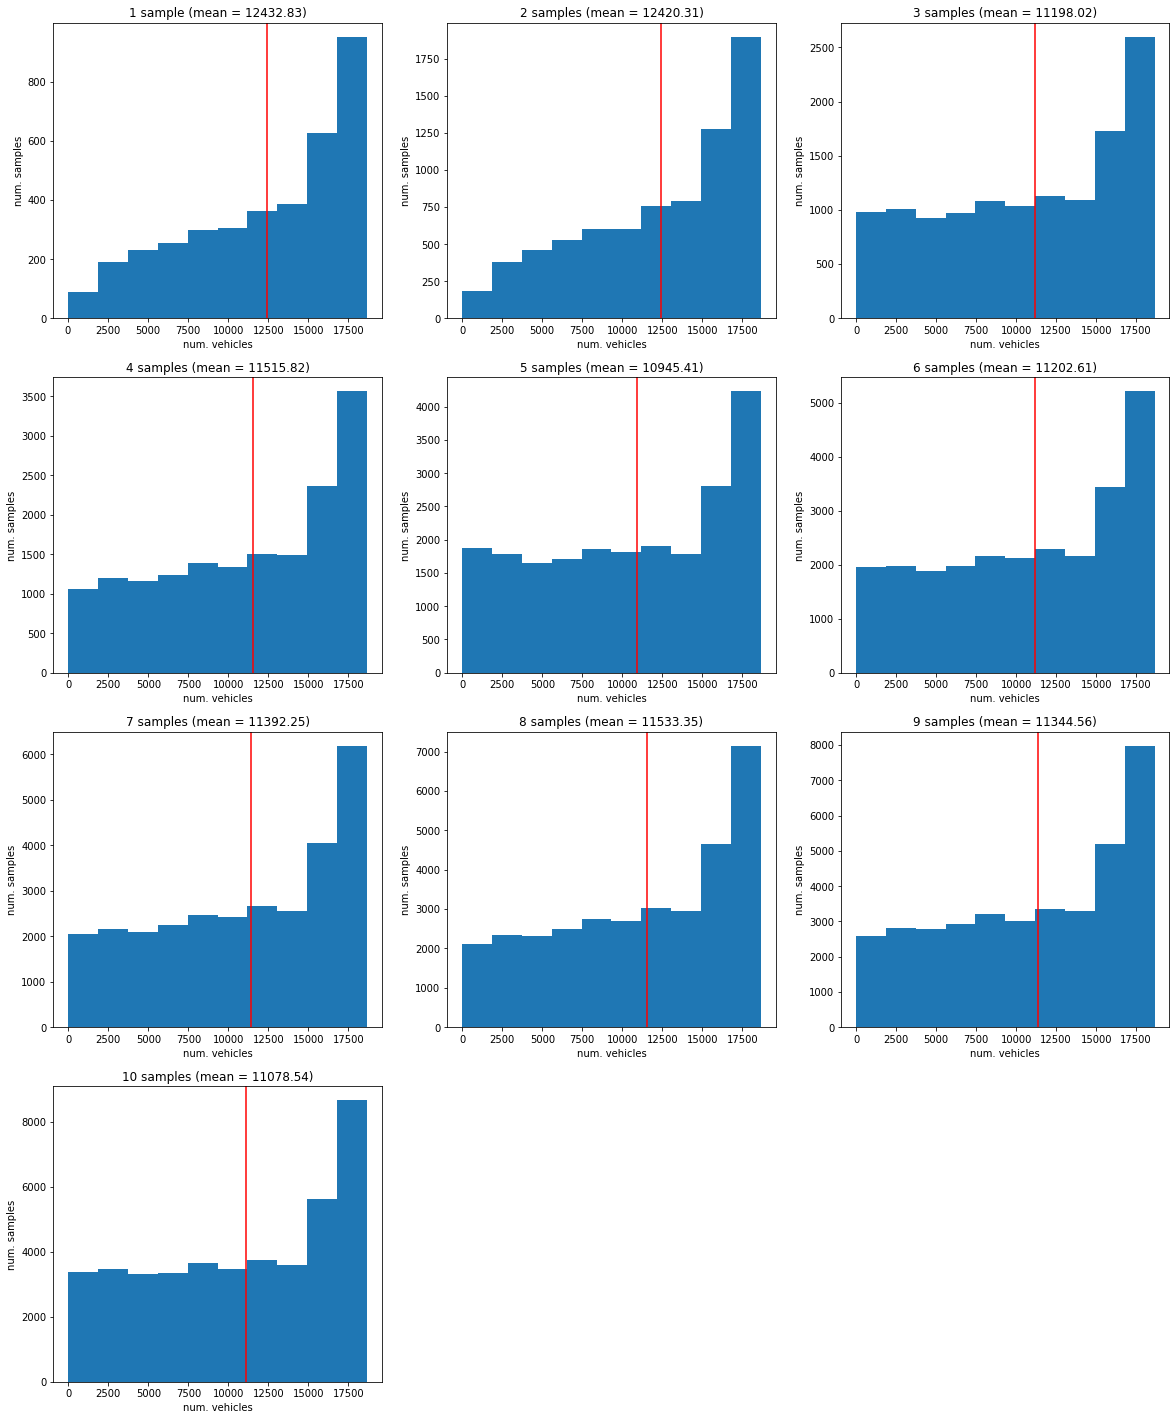

In [32]:
figure = plt.figure(figsize=(20, 25))

# Start from the first experiment
current_df = get_experiment(df_sat, 1)
col = 'num_veh'

all_avg = [np.round(np.mean(current_df[col]), 2)]

for i in range(1, 11):
    if i > 1:
        # If not first iteration
        # then cumulate the next sample.
        df_exp_i = get_experiment(df_sat, i)
        all_avg.append(np.round(np.mean(df_exp_i[col]), 2))
        current_df = pd.concat([current_df, df_exp_i])

    # Plot the cumulated-so-far samples
    current_ax = figure.add_subplot(4, 3, i)
    avg = np.round(np.mean(all_avg), 2)
    if i > 1:
        title = f'{i} samples'
    else:
        title = '1 sample'
    title += f' (mean = {avg})'
    current_ax.hist(current_df[col], density=False)
    plt.title(title);
    plt.axvline(x=avg, color='red');
    plt.xlabel('num. vehicles')
    plt.ylabel('num. samples')

Oh well, the distribution really converges to a almost-uniform distribution. I hadn't look at these 10 plots when I made my conclusions in the previous paragraph!

What could be the reason for it?

I will take a guess, and say that over many cumulated samples the odds of congested traffic (like during rush-hours) vs free-flow (like at 5am) even out and produce a uniform-looking behavior. But I am convinced that if somebody looked at the data more closely, partitioning it based on hours of the day, then the congested trend would clearly appear.

With all that being said, the result still stand: over ten experiments with a few thousand samples each, the most frequent values of number of vehicles are the high values, well above 17,500 vehicles.

## Open questions

That was ... a lot!

A lot of figures, a lot of analysis and thoughts. And I was able to touch just the surface of the data, making two neat conclusions:

  1. Vehicles in Monaco travel at a speed between 37.6 km/h and 38.98 km/h with 95% probability.
  2. The highest capacity experienced by the city is well above 17,500 vehicles, though over one day the instantaneous capacity looks like a uniformly distributed random number.

There's so much more to explore, and so many unanswered questions. Here are a few, off the top of my mind:

 - **From where do most vehicles enter the network?** I think it would be very useful to generate a 2D map of the city that shows the hotspots where a lot of objects enter the city.

 - **What are the most congested spots?** What about a 2D map that shows the most congested spot, where traffic is the worst.

 - **What are the lengths of the 10 longest queues of vehicles? Where are they?**

If you are interested in exploring these questions, remember that the dataset is free and available to everyone, you included. If you start playing with the data, fork this repository and when you're finished submit a PR so we can publish your article!